In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:29]) == "AOI_5_Khartoum"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img665.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img807.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img1686.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img481.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_5_Khartoum_img1557.tif')]

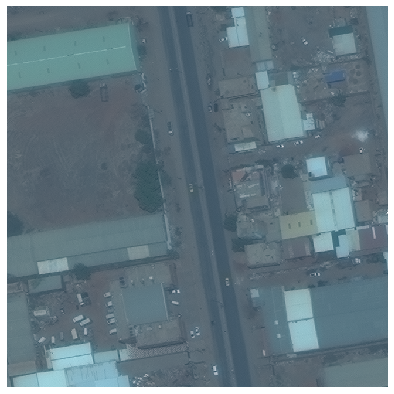

In [6]:
img = open_image(fname[18])
img.show(figsize=(7,7))

In [6]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Khartoum_C_buildings.csv")

In [6]:
khartoum_df = pd.read_csv(path/'Khartoum_C_buildings.csv')
khartoum_df = khartoum_df.drop(columns = 'Unnamed: 0')
khartoum_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_5_Khartoum_img665.tif
1,Images/RGB-PanSharpen_AOI_5_Khartoum_img807.tif
2,Images/RGB-PanSharpen_AOI_5_Khartoum_img481.tif
3,Images/RGB-PanSharpen_AOI_5_Khartoum_img1557.tif
4,Images/RGB-PanSharpen_AOI_5_Khartoum_img50.tif


In [7]:
len(khartoum_df)

923

In [8]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [9]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [10]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(khartoum_df, path).
      split_by_rand_pct(.08).
      label_from_func(get_y_fn, classes=codes))

In [12]:
bs = 64
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.4, max_warp=None,
                      xtra_tfms = [brightness(change=0.57, p=1), contrast(scale=(1.25, 2), p=1.)]), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

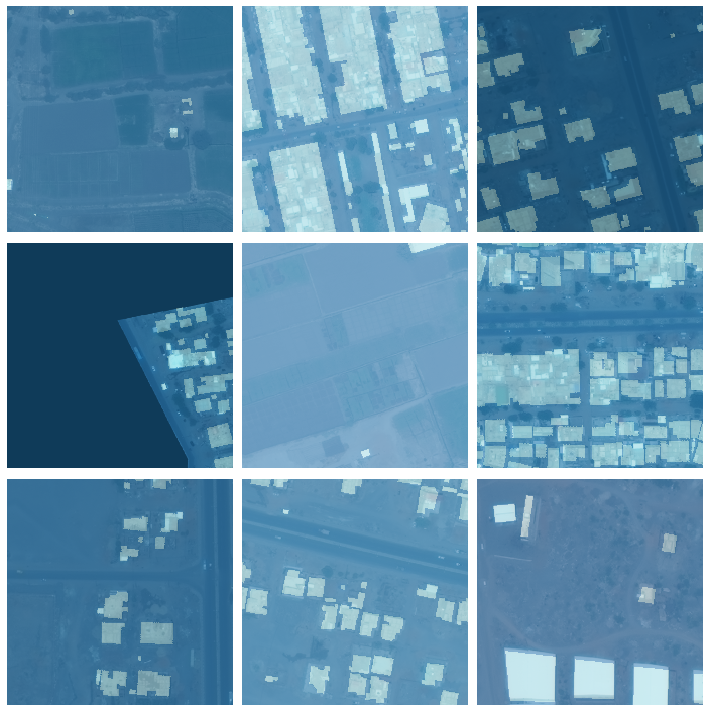

In [17]:
data.show_batch(3, figsize=(10,10))

In [13]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True).to_fp16()
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


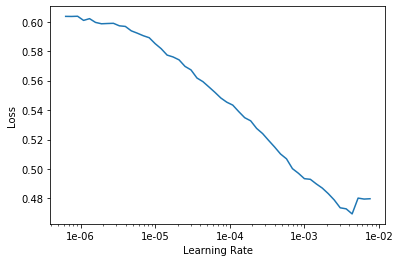

In [14]:
learn.lr_find()
learn.recorder.plot() 

In [15]:
learn.fit_one_cycle(10, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.487056,0.397377,0.011319,00:14
1,0.440336,0.368290,0.097881,00:13
2,0.391332,0.306991,0.353027,00:13
3,0.348873,0.248791,0.436705,00:13
4,0.316248,0.245962,0.360941,00:13
5,0.295335,0.225963,0.496608,00:13
6,0.277710,0.219370,0.480541,00:13
7,0.263397,0.213296,0.547362,00:13
8,0.251920,0.213189,0.542075,00:13
9,0.243059,0.212076,0.539291,00:13


In [16]:
save_model(learn, 'Khartoum_DAC', 'F', 'smol', 1)

# Start Recording

In [11]:
import wandb
from wandb.fastai import WandbCallback

In [18]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [19]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Khartoum.ipynb"

In [20]:
wandb.init(project="spacenet_buildings", name = 'Khartoum_SA_DAC')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/5iyn64cp

In [21]:
load_model(learn, 'Khartoum_DAC', 'F', 'smol', 1)

In [22]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.218709,0.208595,0.530656,00:14
1,0.217484,0.209149,0.564533,00:14
2,0.217691,0.198826,0.575458,00:13
3,0.214681,0.195631,0.553330,00:13
4,0.223575,0.224292,0.436019,00:13
5,0.223106,0.197373,0.567197,00:13
6,0.217847,0.187643,0.591790,00:13
7,0.213687,0.183948,0.597519,00:13
8,0.209806,0.182750,0.596112,00:13
9,0.206675,0.182205,0.596404,00:13


Better model found at epoch 0 with valid_loss value: 0.20859509706497192.
Better model found at epoch 2 with valid_loss value: 0.19882649183273315.
Better model found at epoch 3 with valid_loss value: 0.19563095271587372.
Better model found at epoch 6 with valid_loss value: 0.18764331936836243.
Better model found at epoch 7 with valid_loss value: 0.18394793570041656.
Better model found at epoch 8 with valid_loss value: 0.18275010585784912.
Better model found at epoch 9 with valid_loss value: 0.182205468416214.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_183328-5iyn64cp/bestmodel.pth


In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.195370,0.182239,0.603521,00:14
1,0.194805,0.181182,0.601876,00:14
2,0.195179,0.180314,0.600561,00:14
3,0.194411,0.180111,0.615714,00:14
4,0.194237,0.179130,0.612100,00:14
5,0.193274,0.177546,0.600515,00:14
6,0.191631,0.175701,0.613626,00:13
7,0.190785,0.174931,0.606798,00:14
8,0.189699,0.173870,0.611295,00:14
9,0.189223,0.174178,0.613626,00:14


Better model found at epoch 0 with valid_loss value: 0.18223905563354492.
Better model found at epoch 1 with valid_loss value: 0.1811821311712265.
Better model found at epoch 2 with valid_loss value: 0.18031392991542816.
Better model found at epoch 3 with valid_loss value: 0.18011076748371124.
Better model found at epoch 4 with valid_loss value: 0.17913022637367249.
Better model found at epoch 5 with valid_loss value: 0.17754635214805603.
Better model found at epoch 6 with valid_loss value: 0.17570123076438904.
Better model found at epoch 7 with valid_loss value: 0.17493072152137756.
Better model found at epoch 8 with valid_loss value: 0.1738702952861786.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_183328-5iyn64cp/bestmodel.pth


In [25]:
save_model(learn, 'Khartoum_DAC', 'UF', 'smol', 2)

In [26]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.187600,0.174065,0.612707,00:15
1,0.186140,0.175209,0.618045,00:14
2,0.184858,0.174720,0.616876,00:13
3,0.184456,0.174561,0.616347,00:14
4,0.184829,0.174470,0.616850,00:13
5,0.185354,0.175403,0.620577,00:13
6,0.185815,0.174075,0.616100,00:14
7,0.185440,0.173657,0.617701,00:13
8,0.185958,0.173743,0.618071,00:13
9,0.185979,0.173631,0.617015,00:13


Better model found at epoch 0 with valid_loss value: 0.17406465113162994.
Better model found at epoch 7 with valid_loss value: 0.1736571192741394.
Better model found at epoch 9 with valid_loss value: 0.17363056540489197.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_183328-5iyn64cp/bestmodel.pth


In [27]:
save_model(learn, 'Khartoum_DAC', 'UF', 'smol', 3)

## GO BIG

In [12]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.3, max_lighting = 0.4, max_warp=None,
                      xtra_tfms = [brightness(change=0.57, p=1), contrast(scale=(1.25, 2), p=1.)]), size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [14]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [15]:
load_model(learn, 'Khartoum_DAC', 'UF', 'smol', 3)

In [16]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Khartoum.ipynb"

In [17]:
wandb.init(project="spacenet_buildings", name = 'Khartoum_Big_SA_DAC')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/vi4p915g

In [18]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.197166,0.200294,0.641783,00:45
1,0.193857,0.197167,0.638500,00:28
2,0.202753,0.196726,0.616912,00:29
3,0.200769,0.191634,0.634890,00:29
4,0.196645,0.218095,0.510511,00:28
5,0.195198,0.189553,0.656431,00:29
6,0.199086,0.214238,0.608854,00:28
7,0.191251,0.190473,0.644086,00:29
8,0.179462,0.186296,0.658443,00:29
9,0.172330,0.184568,0.651747,00:29


Better model found at epoch 0 with valid_loss value: 0.20029351115226746.
Better model found at epoch 1 with valid_loss value: 0.19716745615005493.
Better model found at epoch 2 with valid_loss value: 0.1967260092496872.
Better model found at epoch 3 with valid_loss value: 0.19163411855697632.
Better model found at epoch 5 with valid_loss value: 0.18955302238464355.
Better model found at epoch 8 with valid_loss value: 0.18629631400108337.
Better model found at epoch 9 with valid_loss value: 0.18456771969795227.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [19]:
save_model(learn, 'Khartoum_DAC', 'F', 'big', 1)

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.171369,0.184233,0.654375,00:29
1,0.168122,0.181282,0.656472,00:29
2,0.166178,0.184096,0.658817,00:29
3,0.168576,0.181641,0.647399,00:29
4,0.168064,0.182541,0.656658,00:29
5,0.168783,0.178201,0.658255,00:29
6,0.168093,0.179247,0.667976,00:29
7,0.164615,0.177462,0.663404,00:29
8,0.162549,0.175678,0.666158,00:29
9,0.162323,0.175669,0.666888,00:29


Better model found at epoch 0 with valid_loss value: 0.18423284590244293.
Better model found at epoch 1 with valid_loss value: 0.18128228187561035.
Better model found at epoch 5 with valid_loss value: 0.17820051312446594.
Better model found at epoch 7 with valid_loss value: 0.17746183276176453.
Better model found at epoch 8 with valid_loss value: 0.17567786574363708.
Better model found at epoch 9 with valid_loss value: 0.17566902935504913.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [22]:
save_model(learn, 'Khartoum_DAC', 'UF', 'big', 1)

In [23]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.162493,0.175268,0.668377,00:29
1,0.162342,0.175039,0.675429,00:29
2,0.161972,0.175559,0.662799,00:29
3,0.162098,0.173235,0.667736,00:29
4,0.163031,0.176395,0.658461,00:29
5,0.166510,0.178819,0.659877,00:29
6,0.162621,0.172014,0.680604,00:29
7,0.161277,0.170631,0.674236,00:29
8,0.157723,0.170476,0.676736,00:29
9,0.156506,0.170897,0.670518,00:29


Better model found at epoch 0 with valid_loss value: 0.1752680093050003.
Better model found at epoch 1 with valid_loss value: 0.17503881454467773.
Better model found at epoch 3 with valid_loss value: 0.17323514819145203.
Better model found at epoch 6 with valid_loss value: 0.17201407253742218.
Better model found at epoch 7 with valid_loss value: 0.17063122987747192.
Better model found at epoch 8 with valid_loss value: 0.17047613859176636.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [24]:
save_model(learn, 'Khartoum_DAC', 'UF', 'big', 2)

In [25]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.152942,0.170452,0.673611,00:29
1,0.152920,0.170644,0.671919,00:29
2,0.152739,0.169727,0.677757,00:29
3,0.154428,0.170189,0.671674,00:29
4,0.154683,0.170893,0.674164,00:29
5,0.152545,0.167469,0.680128,00:29
6,0.154655,0.169006,0.672029,00:29
7,0.156269,0.168045,0.681909,00:29
8,0.154289,0.168824,0.675032,00:29
9,0.152401,0.168415,0.674718,00:30


Better model found at epoch 0 with valid_loss value: 0.1704520583152771.
Better model found at epoch 2 with valid_loss value: 0.16972729563713074.
Better model found at epoch 5 with valid_loss value: 0.16746941208839417.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [26]:
save_model(learn, 'Khartoum_DAC', 'UF', 'big', 3)

In [27]:
learn.fit_one_cycle(10, slice(5e-7, 1e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.153535,0.167924,0.680666,00:30
1,0.154463,0.167501,0.680124,00:29
2,0.151640,0.167303,0.679674,00:29
3,0.151609,0.167747,0.678186,00:29
4,0.153660,0.168678,0.674887,00:29
5,0.153134,0.167502,0.677501,00:29
6,0.154278,0.167616,0.677297,00:29
7,0.153131,0.168126,0.676460,00:29
8,0.154277,0.168195,0.676089,00:29
9,0.152284,0.167996,0.676374,00:29


Better model found at epoch 0 with valid_loss value: 0.16792353987693787.
Better model found at epoch 1 with valid_loss value: 0.16750119626522064.
Better model found at epoch 2 with valid_loss value: 0.1673029065132141.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [28]:
learn.fit_one_cycle(10, slice(1e-7, 1e-6), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.153540,0.167370,0.679664,00:29
1,0.152291,0.167687,0.679024,00:29
2,0.152544,0.167509,0.678998,00:29
3,0.152823,0.167972,0.677467,00:29
4,0.153999,0.167464,0.678717,00:29
5,0.153231,0.168074,0.675742,00:29
6,0.152708,0.168440,0.675032,00:29
7,0.151017,0.167746,0.676618,00:29
8,0.152563,0.168290,0.676451,00:29
9,0.154488,0.168221,0.675596,00:29


Better model found at epoch 0 with valid_loss value: 0.16737008094787598.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200125_184701-vi4p915g/bestmodel.pth


In [29]:
save_model(learn, 'Khartoum_DAC', 'UF', 'big', 4)